In [1]:
# %% Imports

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import h5py


# Import necessary functions from the modules
from markov_utilities import (
    create_random_epsilon_machine, 
    generate_emissions,
    calculate_steady_state_distribution
)
from visualization import (
    visualize_graph_with_selective_offset, 
    plot_block_entropy_diagram, 
    plot_conditional_entropy_diagram
)
from entropy_analysis import (
    compute_block_entropy, 
    compute_conditional_entropy, 
    compute_empirical_conditional_entropy
)

from error_analysis import (
    compute_minimum_error,
    inverse_binary_entropy,
    binary_entropy
)

# magic for autoreloading modules when they change
%load_ext autoreload
%autoreload 2


In [3]:
# %% CONFIGURATION
CONFIG = {
    'NUM_SYMBOLS': 2,
    'ALPHA': 1.0,
    'NUM_STATES_LIST': [30, 300, 3000],
    'NUM_REPEATS': 100,
    'NUM_EMISSIONS': 1000000,
    'HDF5_BASE_PATH': 'data/results.h5'
}

In [4]:
# %% FUNCTION DEFINITIONS
def generate_and_save_data(num_states, num_repeats, num_symbols, alpha, hdf5_filepath_base):
    """
    Generate epsilon machines, emissions, and results, then save to HDF5.
    """
    hdf5_filepath = hdf5_filepath_base.replace('.h5', f'_{num_states}_states.h5')

    with h5py.File(hdf5_filepath, 'a') as f:

        for repeats in tqdm(range(num_repeats)):
            group_name = f"repeat_{repeats}"
            
            datasets_to_check = ['epsilon_machine', 'emissions', 'results']
            if group_name in f and all(dataset in f[group_name] for dataset in datasets_to_check):
                continue

            # If group exists but not all datasets are there, delete the group to recreate
            if group_name in f:
                del f[group_name]

            _, epsilon_machine = create_random_epsilon_machine(num_states, num_symbols, alpha)
            emissions = generate_emissions(epsilon_machine, CONFIG['NUM_EMISSIONS'])
            conditional_entropies = compute_empirical_conditional_entropy(emissions, 15)

            group = f.create_group(group_name)
            group.create_dataset('epsilon_machine', data=epsilon_machine, compression="gzip", compression_opts=9)
            group.create_dataset('emissions', data=emissions, dtype='uint8')

            results = []
            for block_size, cond_entropy in enumerate(conditional_entropies, 1):
                inverse_entropy = inverse_binary_entropy(cond_entropy)
                min_error = compute_minimum_error(epsilon_machine)
                error_ratio = (inverse_entropy - min_error) / min_error
                results.append({
                    "Block Size": block_size,
                    "Conditional Entropy": cond_entropy,
                    "Inverse Binary Entropy": inverse_entropy,
                    "Minimum Error": min_error,
                    "Error Ratio": error_ratio
                })

            results_df = pd.DataFrame(results)
            rec_array = results_df.to_records(index=False)
            group.create_dataset('results', data=rec_array)


In [5]:
for num_states in CONFIG['NUM_STATES_LIST']:
    generate_and_save_data(
        num_states=num_states, 
        num_repeats=CONFIG['NUM_REPEATS'], 
        num_symbols=CONFIG['NUM_SYMBOLS'], 
        alpha=CONFIG['ALPHA'], 
        hdf5_filepath_base=CONFIG['HDF5_BASE_PATH']
    )

100%|██████████| 100/100 [00:00<00:00, 5001.14it/s]


In [31]:
def extract_and_plot_data(num_states_list, hdf5_filepath_base):
    """
    Extract data from HDF5 files and plot the error ratio vs block size and 
    the conditional entropy vs block size.
    """
    all_results = []

    for num_states in num_states_list:
        hdf5_filepath = hdf5_filepath_base.replace('.h5', f'_{num_states}_states.h5')
        
        with h5py.File(hdf5_filepath, 'r') as f:
            for group_name in f:
                results_array = f[group_name]['results'][:]
                df = pd.DataFrame(results_array)
                df['Number of States'] = num_states
                all_results.append(df)

    final_df = pd.concat(all_results, ignore_index=True)
    # multiply error ratio by 100 for percentage
    final_df['Error Ratio'] = final_df['Error Ratio'] * 100

    # Plotting Conditional Entropy vs Block Size
    sns.set_context('talk')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=final_df, x='Block Size', y='Conditional Entropy', hue='Number of States',
                  palette='bright', errorbar=('ci', 99))
    plt.title('Conditional Entropy vs Block Size')
    plt.ylabel('$h_{\mu}(m)$')
    plt.grid(True)

    # Plotting Error Ratio vs Block Size
    plt.subplot(1, 2, 2)
    sns.lineplot(data=final_df, x='Block Size', y='Error Ratio', hue='Number of States',
                  palette='bright', errorbar=('ci', 99))
    plt.title('Error Ratio vs Block Size')
    plt.ylabel('$(P_e - P_e^{min})/P_e^{min} \\times 100\% $')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


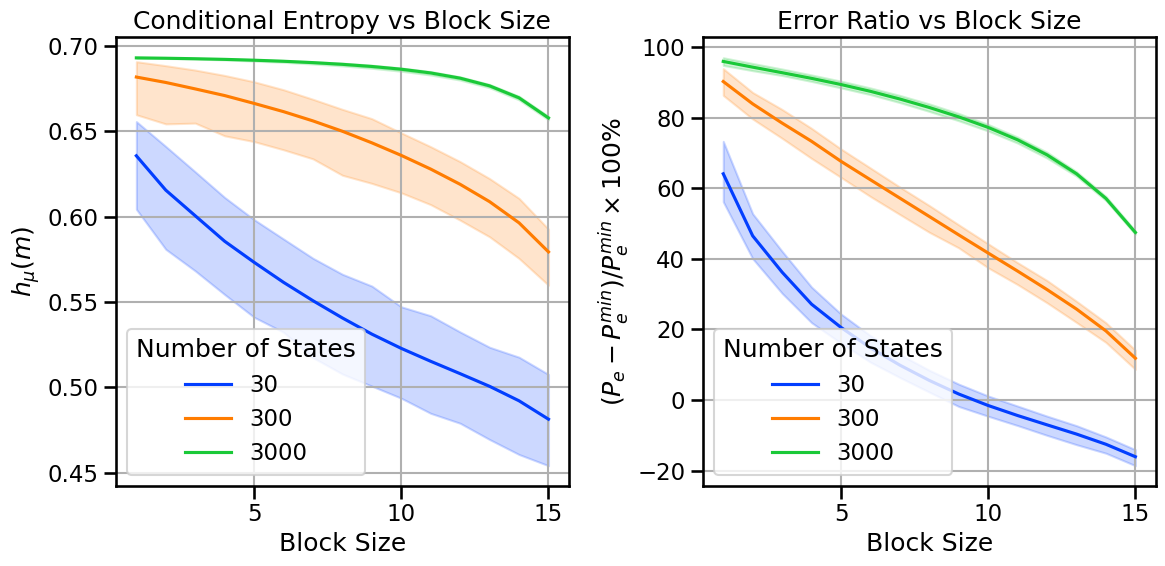

In [32]:
extract_and_plot_data(num_states_list=CONFIG['NUM_STATES_LIST'], hdf5_filepath_base=CONFIG['HDF5_BASE_PATH'])